# Filtrage ondes équatoriales dans l'OLR

Auteur : FERRY Frédéric (ENM/C3M) - février 2021

<img src="spectra.png" alt="drawing" width="400"/>

In [27]:
%matplotlib inline

import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import scipy
import math
from scipy import signal,fftpack, interpolate
from scipy.interpolate import griddata

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.util import add_cyclic_point

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import warnings
warnings.filterwarnings("ignore")

In [28]:
dir_data='./data/'
dir_figs='./figs/'
dir_anim='./anim/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)

# Calcul des anomalies quotidiennes

In [29]:
year1='2000'
year2='2019'
latS=-15.
latN=15.

olr    = xr.open_dataset(dir_data+'olr.day.mean.nc').sel(time=slice(year1,year2)).sel(lat=slice(latN,latS))

print(' ----- Computing daily anomalies ----- ')
olr_anom=olr.groupby('time.dayofyear') - olr.groupby('time.dayofyear').mean('time')

print(olr_anom)

print(' ----- Writing netcdf ----- ')
dataDIR = './result/olr.anom.'+year1+'-'+year2+'.nc'
olr_anom.to_netcdf(dataDIR)

 ----- Computing daily anomalies ----- 
<xarray.Dataset>
Dimensions:    (lat: 13, lon: 144, nmiss: 7, time: 7305)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 15.0 12.5 10.0 7.5 5.0 ... -7.5 -10.0 -12.5 -15.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Dimensions without coordinates: nmiss
Data variables:
    info       (time, nmiss) float32 -302.5 1.55 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    olr        (time, lat, lon) float32 -35.08 -9.507 -5.15 ... 7.125 -0.3625
 ----- Writing netcdf ----- 


# Filtrage spectral

In [30]:
def kf_filter(inData,obsPerDay,tMin,tMax,kMin,kMax,hMin,hMax,waveName):
	timeDim = inData.shape[0]
	lonDim = inData.shape[1]
	
	# Reshape data from [time,lon] to [lon,time]
	originalData=np.zeros([lonDim,timeDim],dtype='f')
	for counterX in range(timeDim):
	    test=0
	    for counterY in range(lonDim-1,-1,-1):
	        originalData[test,counterX]=inData[counterX,counterY]
	        test+=1
	
	# Detrend the Data
	detrendData=np.zeros([lonDim,timeDim],dtype='f')
	for counterX in range(lonDim):
	    detrendData[counterX,:]=signal.detrend(originalData[counterX,:])
	
	# Taper 
	taper=signal.tukey(timeDim,0.05,True)
	taperData=np.zeros([lonDim,timeDim],dtype='f')
	for counterX in range(lonDim):
	    taperData[counterX,:]=detrendData[counterX,:]*taper
	
	# Perform 2-D Fourier Transform
	fftData=np.fft.rfft2(taperData)
	kDim=lonDim 
	freqDim=round(fftData.shape[1])
	
	# Find the indeces for the period cut-offs
	jMin = int(round( ( timeDim * 1. / ( tMax * obsPerDay ) ), 0 ))
	jMax = int(round( ( timeDim * 1. / ( tMin * obsPerDay ) ), 0 ))
	jMax = min( ( jMax, freqDim ) )

	# Find the indices for the wavenumber cut-offs
	# This is more complicated because east and west are separate
	if( kMin < 0 ):
	    iMin = round( ( kDim + kMin ), 3 )
	    iMin = max( ( iMin, ( kDim / 2 ) ) )
	else:
	    iMin = round( kMin, 3 )
	    iMin = min( ( iMin, ( kDim / 2 ) ) )

	if( kMax < 0 ):
	    iMax = round( ( kDim + kMax ), 3 )
	    iMax = max( ( iMax, ( kDim / 2 ) ) )
	else:
	    iMax = round( kMax, 3 )
	    iMax = min( ( iMax, ( kDim / 2 ) ) )
	  
	# set the appropriate coefficients to zero
	iMin=int(iMin)
	iMax=int(iMax)
	jMin=int(jMin)
	jMax=int(jMax)
	if( jMin > 0 ):
	    fftData[:, :jMin-1 ] = 0
	if( jMax < ( freqDim - 1 ) ):
	    fftData[:, jMax+1: ] = 0

	if( iMin < iMax ):
	    # Set things outside the range to zero, this is more normal
	    if( iMin > 0 ):
	        fftData[:iMin-1, : ] = 0
	    if( iMax < ( kDim - 1 ) ):
	        fftData[iMax+1:, : ] = 0
	else:
	    # Set things inside the range to zero, this should be somewhat unusual
	    fftData[iMax+1:iMin-1, : ] = 0
	
	# Find constants
	PI = math.pi
	beta = 2.28e-11
	if hMin != -999:
	    cMin = float( 9.8 * float(hMin) )**0.5
	else:
	    cMin=hMin
	if hMax != -999:
	    cMax = float( 9.8 * float(hMax) )**0.5
	else:
	    cMax=hMax
	c = np.array([cMin,cMax])
	spc = 24 * 3600. / ( 2 * PI * obsPerDay ) # seconds per cycle
	
	# Now set things to zero that are outside the Kelvin dispersion
	for i in range(0,kDim):
		# Find Non-Dimensional WaveNumber (k)
		if( i > ( kDim / 2 ) ):
			# k is negative
			k = ( i - kDim  ) * 1. / (6.37e6) # adjusting for circumfrence of earth
		else:
			# k is positive
			k = i * 1. / (6.37e6) # adjusting for circumfrence of earth
		
		# Find Frequency
		freq = np.array([ 0, freqDim * (1. / spc) ]) #waveName='None'
		jMinWave = 0
		jMaxWave = freqDim	
		if waveName.lower() == "kelvin":
		    freq = k * c
		if waveName.lower() == "er":
		    freq = -beta * k / ( k**2 + 3. * beta / c )
		if waveName.lower() == "ig1":
		    freq = ( 3 * beta * c + k**2 * c**2 )**0.5
		if waveName.lower() == "ig2":
		    freq = ( 5 * beta * c + k**2 * c**2 )**0.5
		if waveName.lower() == "mrg" or waveName.lower()=="ig0":   	
			if( k == 0 ):
				freq = ( beta * c )**0.5
			else:
				if( k > 0):
					freq = k * c * ( 0.5 + 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )
				else:
					freq = k * c * ( 0.5 - 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )	
		
		# Get Min/Max Wave 
		if(hMin==mis):
		    jMinWave = 0
		else:
		    jMinWave = int( math.floor( freq[0] * spc * timeDim ) )

		if(hMax==mis):
		    jMaxWave = freqDim
		else:
		    jMaxWave = int( math.ceil( freq[1] * spc * timeDim ) )

		jMaxWave = max(jMaxWave, 0)
		jMinWave = min(jMinWave, freqDim)
		
		# set the appropriate coefficients to zero
		i=int(i)
		jMinWave=int(jMinWave)
		jMaxWave=int(jMaxWave)
		if( jMinWave > 0 ):
		    fftData[i, :jMinWave-1] = 0
		if( jMaxWave < ( freqDim - 1 ) ):
		    fftData[i, jMaxWave+1:] = 0
	
	# perform the inverse transform to reconstruct the data
	returnedData=np.fft.irfft2(fftData) 
	
	# Reshape data from [lon,time] to [time,lon]
	outData=np.zeros([timeDim,lonDim],dtype='f')
	for counterX in range(returnedData.shape[1]):
	    test=0
	    for counterY in range(lonDim-1,-1,-1):
	        outData[counterX,counterY]=returnedData[test,counterX] 
	        test+=1
    
    # Return Result
	return outData

In [31]:
season_name='NDJFM'
#season_name='MJJAS'

# Données entre 15S et 15N
data_olr=olr_anom.sel(lat=slice(15,-15))
lat = data_olr.lat.values
lon = data_olr.lon.values
time = data_olr.time.values

# Période totale des données
print(time)
d1=time[0]
d2=time[-1]
dates = pd.date_range(d1, d2, freq='D')
print(dates)

# Select Season
if season_name == 'NDJFM':
    months=np.any([dates.month==11,dates.month==12,dates.month==1,dates.month==2,dates.month==3],axis=0)
if season_name == 'MJJAS':
    months=np.any([dates.month==5,dates.month==6,dates.month==7,dates.month==8,dates.month==9],axis=0)

dates2=dates[months]
print(dates2)

data_season = data_olr.sel(time=dates2)
time = data_season.time.values
data=data_season['olr']
filtData=data
print(filtData)

['2000-01-01T00:00:00.000000000' '2000-01-02T00:00:00.000000000'
 '2000-01-03T00:00:00.000000000' ... '2019-12-29T00:00:00.000000000'
 '2019-12-30T00:00:00.000000000' '2019-12-31T00:00:00.000000000']
DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=7305, freq='D')
DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
   

In [32]:
backup=np.array(filtData,dtype='f')

In [33]:
# Filter MJO : Kiladis et al. (2005 JAS) for 20-100
mjo_wavenumber=[0,9]
mjo_period=[20,100]

# Filter Kelvin Straub & Kiladis (2002) to 20 days
kelvin_wavenumber=[1,14]
kelvin_period=[2.5,20]

# Filter ER : Kiladis et al. (2009 Rev. Geophys.)
er_wavenumber=[-10,-1]
er_period=[9.7,72]

# Filter MRG : Wheeler & Kiladis (1999)
mrg_wavenumber=[-10,-1]
mrg_period=[3,96]

# Filter (Low) >120d
low_wavenumber=[-10,10]
low_period=[120,9999]

mis = -999
obsPerDay = 1 # données quotidiennes

In [34]:
print("\n##############################\nFiltering (MJO)\n")

mjo = np.array(filtData,dtype='f')
mjo_wavenumber=np.array(mjo_wavenumber,dtype='f')
mjo_period=np.array(mjo_period,dtype='f')
mjo_depth=np.array([mis,mis],dtype='f')

for lat_counter in range(0,len(lat)):
	print("###########################################################################################")
	print(lat_counter,lat[lat_counter])
	mjo[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
		mjo_period[0],mjo_period[1],\
		mjo_wavenumber[0],mjo_wavenumber[1],\
		mjo_depth[0],mjo_depth[1],"none")
	print(np.min(mjo[:,lat_counter,:]),np.max(mjo[:,lat_counter,:]))

# Reset FiltData
filtData=np.zeros([len(time),len(lat),len(lon)],dtype='f')
for x in range(0,filtData.shape[0]):
  for y in range(0,filtData.shape[1]):
    for z in range(0,filtData.shape[2]):
      filtData[x,y,z]=backup[x,y,z]


##############################
Filtering (MJO)

###########################################################################################
0 15.0
-37.293686 43.388924
###########################################################################################
1 12.5
-40.33303 48.407032
###########################################################################################
2 10.0
-43.3409 52.015984
###########################################################################################
3 7.5
-47.121902 55.34904
###########################################################################################
4 5.0
-55.604137 54.289078
###########################################################################################
5 2.5
-55.59148 52.065434
###########################################################################################
6 0.0
-55.308098 52.087433
###########################################################################################
7 -2.5
-64.19471 49.968494
#

In [35]:
print("\n##############################\nFiltering (ER)\n")

er = filtData
er_wavenumber=np.array(er_wavenumber,dtype='f')
er_period=np.array(er_period,dtype='f')
er_depth=np.array([mis,mis],dtype='f')

for lat_counter in range(0,len(lat)):
	print("###########################################################################################")
	print(lat_counter,lat[lat_counter])
	er[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
		er_period[0],er_period[1],\
		er_wavenumber[0],er_wavenumber[1],\
		er_depth[0],er_depth[1],"er")
	print(np.min(er[:,lat_counter,:]),np.max(er[:,lat_counter,:]))

# Reset FiltData
filtData=np.zeros([len(time),len(lat),len(lon)],dtype='f')
for x in range(0,filtData.shape[0]):
  for y in range(0,filtData.shape[1]):
    for z in range(0,filtData.shape[2]):
      filtData[x,y,z]=backup[x,y,z]


##############################
Filtering (ER)

###########################################################################################
0 15.0
-61.83394 50.216526
###########################################################################################
1 12.5
-70.86865 63.39756
###########################################################################################
2 10.0
-64.06249 70.24167
###########################################################################################
3 7.5
-63.34149 71.512955
###########################################################################################
4 5.0
-59.632736 55.427555
###########################################################################################
5 2.5
-61.338295 47.024944
###########################################################################################
6 0.0
-56.033707 45.330273
###########################################################################################
7 -2.5
-54.942066 55.63396
###

In [36]:
print("\n##############################\nFiltering (Low)\n")

low = filtData
low_wavenumber=np.array(low_wavenumber,dtype='f')
low_period=np.array(low_period,dtype='f')
low_depth=np.array([mis,mis],dtype='f')

for lat_counter in range(0,len(lat)):
	print("###########################################################################################")
	print(lat_counter,lat[lat_counter])
	low[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
		low_period[0],low_period[1],\
		low_wavenumber[0],low_wavenumber[1],\
		low_depth[0],low_depth[1],"none")
	print(np.min(low[:,lat_counter,:]),np.max(low[:,lat_counter,:]))

# Reset FiltData
filtData=np.zeros([len(time),len(lat),len(lon)],dtype='f')
for x in range(0,filtData.shape[0]):
  for y in range(0,filtData.shape[1]):
    for z in range(0,filtData.shape[2]):
      filtData[x,y,z]=backup[x,y,z]


##############################
Filtering (Low)

###########################################################################################
0 15.0
-29.375063 28.332432
###########################################################################################
1 12.5
-34.89623 34.79579
###########################################################################################
2 10.0
-37.30318 42.695827
###########################################################################################
3 7.5
-34.592026 43.187035
###########################################################################################
4 5.0
-56.091293 51.705162
###########################################################################################
5 2.5
-78.50243 59.071148
###########################################################################################
6 0.0
-80.874886 58.173176
###########################################################################################
7 -2.5
-73.03677 52.76957
#

In [37]:
print("\n##############################\nFiltering (KELVIN)\n")

kelvin = filtData
kelvin_wavenumber=np.array(kelvin_wavenumber,dtype='f')
kelvin_period=np.array(kelvin_period,dtype='f')
kelvin_depth=np.array([8,90],dtype='f')

for lat_counter in range(0,len(lat)):
	print("###########################################################################################")
	print(lat_counter,lat[lat_counter])
	
	kelvin[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
	           kelvin_period[0],kelvin_period[1],\
	           kelvin_wavenumber[0],kelvin_wavenumber[1],\
	           kelvin_depth[0],kelvin_depth[1],"kelvin")
	print(np.min(kelvin[:,lat_counter,:]),np.max(kelvin[:,lat_counter,:]))

# Reset FiltData
filtData=np.zeros([len(time),len(lat),len(lon)],dtype='f')
for x in range(0,filtData.shape[0]):
  for y in range(0,filtData.shape[1]):
    for z in range(0,filtData.shape[2]):
      filtData[x,y,z]=backup[x,y,z]


##############################
Filtering (KELVIN)

###########################################################################################
0 15.0
-57.318336 44.60407
###########################################################################################
1 12.5
-62.9132 39.99262
###########################################################################################
2 10.0
-54.42544 45.95651
###########################################################################################
3 7.5
-56.122654 46.346386
###########################################################################################
4 5.0
-55.219673 51.57954
###########################################################################################
5 2.5
-53.87225 55.950474
###########################################################################################
6 0.0
-64.68591 52.93998
###########################################################################################
7 -2.5
-56.43443 47.061016
###

In [38]:
print("\n##############################\nFiltering (MRG)\n")

mrg = filtData
mrg_wavenumber=np.array(mrg_wavenumber,dtype='f')
mrg_period=np.array(mrg_period,dtype='f')
mrg_depth=np.array([8,90],dtype='f')

for lat_counter in range(0,len(lat)):
	print("###########################################################################################")
	print(lat_counter,lat[lat_counter])
	
	mrg[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
	           mrg_period[0],mrg_period[1],\
	           mrg_wavenumber[0],mrg_wavenumber[1],\
	           mrg_depth[0],mrg_depth[1],"mrg")
	print(np.min(mrg[:,lat_counter,:]),np.max(mrg[:,lat_counter,:]))

# Reset FiltData
filtData=np.zeros([len(time),len(lat),len(lon)],dtype='f')
for x in range(0,filtData.shape[0]):
  for y in range(0,filtData.shape[1]):
    for z in range(0,filtData.shape[2]):
      filtData[x,y,z]=backup[x,y,z]


##############################
Filtering (MRG)

###########################################################################################
0 15.0
-30.879921 31.237892
###########################################################################################
1 12.5
-32.882072 33.662354
###########################################################################################
2 10.0
-37.756393 36.005043
###########################################################################################
3 7.5
-37.339977 37.16722
###########################################################################################
4 5.0
-31.265652 32.157738
###########################################################################################
5 2.5
-24.887276 24.489058
###########################################################################################
6 0.0
-24.643213 24.18986
###########################################################################################
7 -2.5
-31.891756 32.9560

# Sauvegarde des champs

In [39]:
mjo_nc = xr.DataArray(mjo,dims=['time', 'lat', 'lon'], coords={'time': time, 'lat': lat, 'lon': lon})
dataDIR = './result/olr.mjo.'+season_name+'.'+year1+'-'+year2+'.nc'
mjo_nc.to_netcdf(dataDIR)

er_nc = xr.DataArray(er,dims=['time', 'lat', 'lon'], coords={'time': time, 'lat': lat, 'lon': lon})
dataDIR = './result/olr.er.'+season_name+'.'+year1+'-'+year2+'.nc'
er_nc.to_netcdf(dataDIR)

kelvin_nc = xr.DataArray(kelvin,dims=['time', 'lat', 'lon'], coords={'time': time, 'lat': lat, 'lon': lon})
dataDIR = './result/olr.kelvin.'+season_name+'.'+year1+'-'+year2+'.nc'
kelvin_nc.to_netcdf(dataDIR)

low_nc = xr.DataArray(low,dims=['time', 'lat', 'lon'], coords={'time': time, 'lat': lat, 'lon': lon})
dataDIR = './result/olr.low.'+season_name+'.'+year1+'-'+year2+'.nc'
low_nc.to_netcdf(dataDIR)

mrg_nc = xr.DataArray(mrg,dims=['time', 'lat', 'lon'], coords={'time': time, 'lat': lat, 'lon': lon})
dataDIR = './result/olr.mrg.'+season_name+'.'+year1+'-'+year2+'.nc'
mrg_nc.to_netcdf(dataDIR)

In [40]:
var=np.var(filtData,axis=0)
mjo_var=np.var(mjo,axis=0)
er_var=np.var(er,axis=0)
kelvin_var=np.var(kelvin,axis=0)
mrg_var=np.var(mrg,axis=0)
low_var=np.var(low,axis=0)
print(mjo_var.shape)

(13, 144)


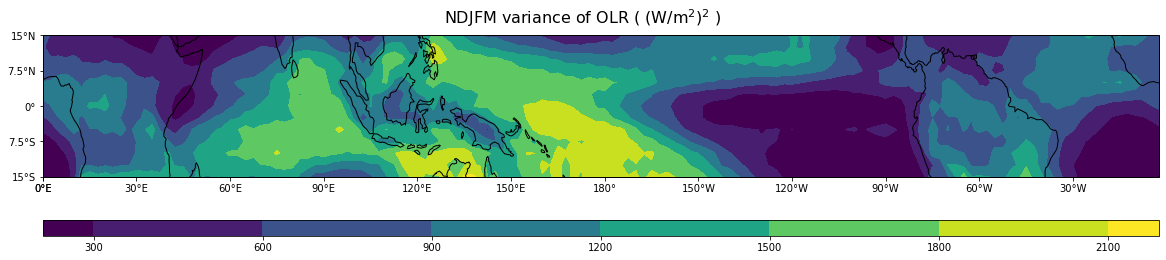

In [41]:
lonW=lon[0]
lonE=lon[-1]

bounds = [(lonW, lonE, -15, 15)]

def plot_background(ax):
   ax.set_xticks(np.linspace(0, 360, 13), crs=ccrs.PlateCarree())
   ax.set_yticks(np.linspace(latS, latN, 5), crs=ccrs.PlateCarree())
   ax.axes.axis('tight')
   lon_formatter = LongitudeFormatter(zero_direction_label=True)
   lat_formatter = LatitudeFormatter()
   ax.xaxis.set_major_formatter(lon_formatter)
   ax.yaxis.set_major_formatter(lat_formatter)
   ax.coastlines()
   ax.set_extent(*bounds, crs=ccrs.PlateCarree())
   return ax

fig = plt.figure(figsize=(20., 4.))
fig.suptitle(season_name+' variance of OLR ( (W/m$^2$)$^2$ )', fontsize=16)

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180.0))
plot_background(ax)
cf = ax.contourf(lon, lat, var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')
    
figname='./figs/OLR_variance_'+season_name
fig.savefig(figname+'.png')
plt.show()

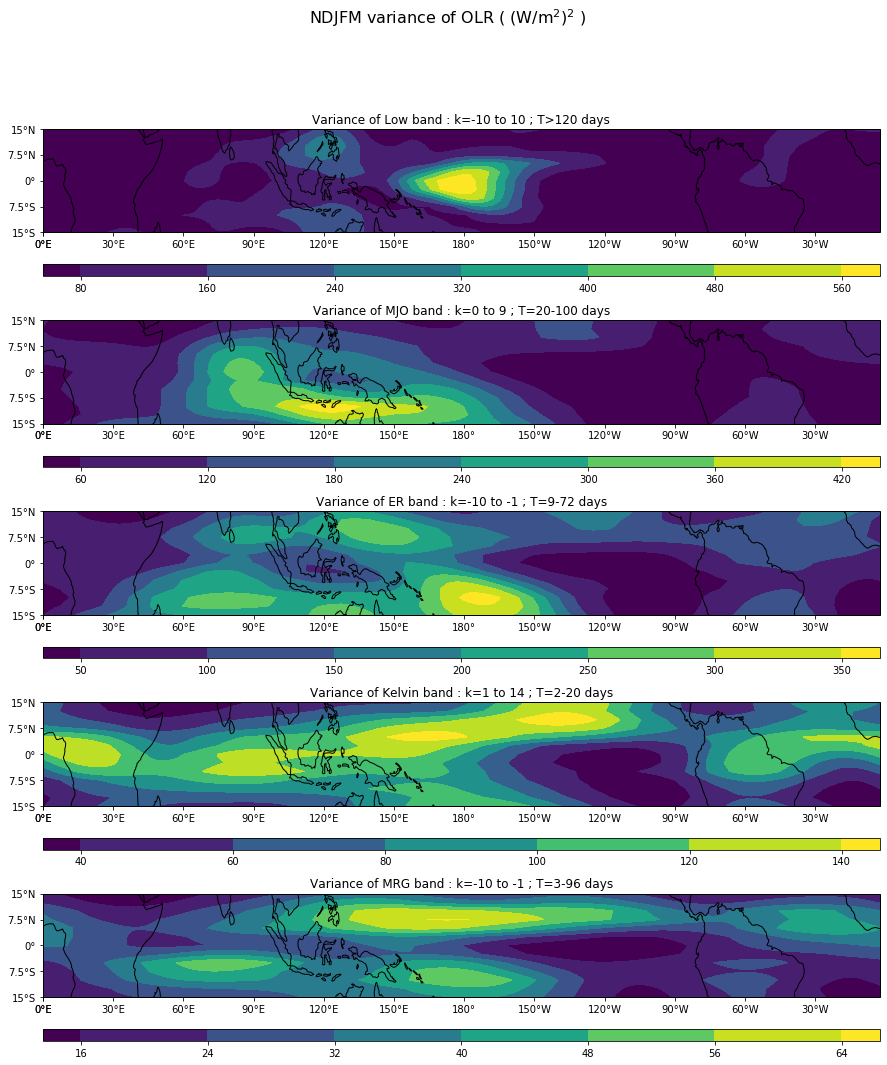

In [42]:
lonW=lon[0]
lonE=lon[-1]

bounds = [(lonW, lonE, -15, 15)]

def plot_background(ax):
   ax.set_xticks(np.linspace(0, 360, 13), crs=ccrs.PlateCarree())
   ax.set_yticks(np.linspace(latS, latN, 5), crs=ccrs.PlateCarree())
   ax.axes.axis('tight')
   lon_formatter = LongitudeFormatter(zero_direction_label=True)
   lat_formatter = LatitudeFormatter()
   ax.xaxis.set_major_formatter(lon_formatter)
   ax.yaxis.set_major_formatter(lat_formatter)
   ax.coastlines()
   ax.set_extent(*bounds, crs=ccrs.PlateCarree())
   return ax

fig = plt.figure(figsize=(15., 17.))
fig.suptitle(season_name+' variance of OLR ( (W/m$^2$)$^2$ )', fontsize=16)

ax = fig.add_subplot(511, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_title('Variance of Low band : k='
             +str(round(int(low_wavenumber[0])))+' to '+str(round(int(low_wavenumber[1])))
             +' ; T>'
             +str(round(int(low_period[0])))
             +' days', loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, low_var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(512, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_title('Variance of MJO band : k='
             +str(round(int(mjo_wavenumber[0])))+' to '+str(round(int(mjo_wavenumber[1])))
             +' ; T='
             +str(round(int(mjo_period[0])))+'-'+str(round(int(mjo_period[1])))
             +' days', loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, mjo_var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')
    
ax = fig.add_subplot(513, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_title('Variance of ER band : k='
             +str(round(int(er_wavenumber[0])))+' to '+str(round(int(er_wavenumber[1])))
             +' ; T='
             +str(round(int(er_period[0])))+'-'+str(round(int(er_period[1])))
             +' days', loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, er_var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')
    
ax = fig.add_subplot(514, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_title('Variance of Kelvin band : k='
             +str(round(int(kelvin_wavenumber[0])))+' to '+str(round(int(kelvin_wavenumber[1])))
             +' ; T='
             +str(round(int(kelvin_period[0])))+'-'+str(round(int(kelvin_period[1])))
             +' days', loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, kelvin_var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_title('Variance of MRG band : k='
             +str(round(int(mrg_wavenumber[0])))+' to '+str(round(int(mrg_wavenumber[1])))
             +' ; T='
             +str(round(int(mrg_period[0])))+'-'+str(round(int(mrg_period[1])))
             +' days', loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, mrg_var,  transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')
    
figname='./figs/OLR_waves_variance_'+season_name
fig.savefig(figname+'.png')
plt.show()